In this notebook, the practice of the lifetime package and estimate customer lifetime value is conducted.

Reference: 
1. clv learning: https://www.youtube.com/watch?v=486x8ccQThE
2. dataset used: https://www.kaggle.com/datasets/nathaniel/uci-online-retail-ii-data-set also available at [UCI Repo] (https://archive.ics.uci.edu/dataset/502/online+retail+ii)
3. notebook looked as helping hand: https://www.kaggle.com/code/halimedogan/crm-analytics-cltv/notebook

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
    
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data as summary
from lifetimes.utils import _customer_lifetime_value 

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
sns.set_palette("pastel")

In [2]:
import os
print(os.getcwd())

c:\Users\Monika\Projects\Customer Life-time Value\Learning\clv_practice1_uci


## Load data

In [3]:
df1 = pd.read_excel(r"uci_online_retail_II.xlsx", sheet_name="Year 2009-2010")
df2 = pd.read_excel(r"uci_online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [ ]:
df1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df2.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
def check_df(dataframe):
    print("################ Shape ####################")
    print(dataframe.shape)
    print("############### Types #####################")
    print(dataframe.dtypes)
    print("############### Unique Value Counts ###################")
    print(dataframe.nunique())
    print("############### NA Counts ########################")
    print(dataframe.isnull().sum())

In [7]:
check_df(df1)

################ Shape ####################
(525461, 8)
############### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
############### Unique Value Counts ###################
Invoice        28816
StockCode       4632
Description     4681
Quantity         825
InvoiceDate    25296
Price           1606
Customer ID     4383
Country           40
dtype: int64
############### NA Counts ########################
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


In [8]:
check_df(df2)

################ Shape ####################
(541910, 8)
############### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
############### Unique Value Counts ###################
Invoice        25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
Price           1630
Customer ID     4372
Country           38
dtype: int64
############### NA Counts ########################
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64


## analysis of data values
- to create dataframe compatible with lifetimes library

In [35]:
df1_nullCID_Invoice = df1.loc[df1['Customer ID'].isna()]['Invoice'].unique()
df2_nullCID_Invoice = df2.loc[df2['Customer ID'].isna()]['Invoice'].unique()

print("Number of unique invoices with null Customer ID in dataframe:")
print(f"df1: {df1_nullCID_Invoice.shape[0]} out of {df1['Invoice'].nunique()}")
print(f"df2: {df2_nullCID_Invoice.shape[0]} out of {df2['Invoice'].nunique()}")


Number of unique invoices with null Customer ID in dataframe:
df1: 5229 out of 28816
df2: 3710 out of 25900


In [ ]:
df1_withCID_Invoice_record = df1.loc[~df1['Customer ID'].isna()]['Invoice']

df2_withCID_Invoice_record = df2.loc[~df2['Customer ID'].isna()]['Invoice']

print('Count of invoices with a Customer ID also appear without a Customer ID')
print('df1:', 
        df1_withCID_Invoice_record.isin(df1_nullCID_Invoice).sum())

print('df2:',
        df2_withCID_Invoice_record.isin(df2_nullCID_Invoice).sum())

Count of invoices with a Customer ID also appear without a Customer ID
df1: 0
df2: 0


Given the above, we can conclude that the null Customer IDs cannot be imputed and cannot be used for analysis.

In [ ]:
df1.groupby('Invoice')[['Customer ID']].nunique().eq(1).all(axis=1).sum()

np.int64(23587)

In [42]:
df1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### unique invoice record

In [18]:
def transform_data(data, ignore_na=True):
    data = data.copy()
    
    if ignore_na:
        data = data[~data['Customer ID'].isna()]
        
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    data['Invoice'] = data['Invoice'].astype(str)
    data['Customer ID'] = data['Customer ID'].astype(int)
    data['Amount'] = data['Quantity'] * data['Price']
    
    # aggregate template
    agg_dict = {
        'InvoiceDate': lambda x: x.iloc[0] if x.nunique() == 1 else x.max(), # in 1st attempt it was pd.NaT
        'Customer ID': lambda x: x.iloc[0] if x.nunique() == 1 else 'Multiple',
        'Country': lambda x: x.iloc[0] if x.nunique() == 1 else 'Multiple',
        'Amount': 'sum',
        'Quantity': list,
        'Price': list,
        'StockCode': list,
        'Description': list
    }
    grouped = data.groupby('Invoice', as_index=False).agg(agg_dict)

    # Add new columns after aggregation
    grouped['TotalItems'] = grouped['Quantity'].apply(sum)
    grouped['NumUniqueProd'] = grouped['StockCode'].apply(len)
    grouped['AvgPrice'] = grouped['Price'].apply(lambda x: round(sum(x)/len(x), 2))
    

    return grouped

In [19]:
df1_summary = transform_data(df1)
df2_summary = transform_data(df2)

In [11]:
df2[df2['Customer ID'] == 12350.0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
80323,543037,21908,CHOCOLATE THIS WAY METAL SIGN,12,2011-02-02 16:01:00,2.10,12350.0,Norway
80324,543037,22412,METAL SIGN NEIGHBOURHOOD WITCH,12,2011-02-02 16:01:00,2.10,12350.0,Norway
80325,543037,79066K,RETRO MOD TRAY,10,2011-02-02 16:01:00,0.85,12350.0,Norway
80326,543037,79191C,RETRO PLASTIC ELEPHANT TRAY,12,2011-02-02 16:01:00,0.85,12350.0,Norway
80327,543037,22348,TEA BAG PLATE RED RETROSPOT,24,2011-02-02 16:01:00,0.85,12350.0,Norway
80328,543037,84086C,PINK/PURPLE RETRO RADIO,6,2011-02-02 16:01:00,2.95,12350.0,Norway
80329,543037,22551,PLASTERS IN TIN SPACEBOY,12,2011-02-02 16:01:00,1.65,12350.0,Norway
80330,543037,22557,PLASTERS IN TIN VINTAGE PAISLEY,12,2011-02-02 16:01:00,1.65,12350.0,Norway
80331,543037,21832,CHOCOLATE CALCULATOR,12,2011-02-02 16:01:00,1.65,12350.0,Norway
80332,543037,21915,RED HARMONICA IN BOX,12,2011-02-02 16:01:00,1.25,12350.0,Norway


In [13]:
df2_summary[df2_summary['Customer ID'] == 12350]

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
2496,543037,2011-02-02 16:01:00,12350,Norway,334.4,"[12, 12, 10, 12, 24, 6, 12, 12, 12, 12, 12, 12...","[2.1, 2.1, 0.85, 0.85, 0.85, 2.95, 1.65, 1.65,...","[21908, 22412, 79066K, 79191C, 22348, 84086C, ...","[CHOCOLATE THIS WAY METAL SIGN, METAL SIGN NEI...",197,17,3.84


In [14]:
print('unique customers:')
print('df1:', df1['Customer ID'].nunique())
print('df2:', df2['Customer ID'].nunique())
print('df1_summary', df1_summary['Customer ID'].nunique())
print('df2_summary', df2_summary['Customer ID'].nunique())

unique customers:
df1: 4383
df2: 4372
df1_summary 4383
df2_summary 4372


In [15]:
print(f'{df1_summary[df1_summary['Customer ID'] == 'Multiple'].shape[0]} df1 invoices with multiple customers')
print(f'{df1_summary[df1_summary['Country'] == 'Multiple'].shape[0]} df1 invoices with multiple countries')

print(f'{df2_summary[df2_summary['Customer ID'] == 'Multiple'].shape[0]} df2 invoices with multiple customers')
print(f'{df2_summary[df2_summary['Country'] == 'Multiple'].shape[0]} df2 invoices with multiple countries')

0 df1 invoices with multiple customers
0 df1 invoices with multiple countries
0 df2 invoices with multiple customers
0 df2 invoices with multiple countries


In [41]:
print(df1['Customer ID'].nunique() == df1_summary['Customer ID'].nunique())
print(df2['Customer ID'].nunique() == df2_summary['Customer ID'].nunique())

True
True


In [12]:
df1_summary.tail()

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
23582,C538121,2010-12-09 15:36:00,15535.0,United Kingdom,-12.75,[-1],[12.75],[22461],[SAVOY ART DECO CLOCK],-1,1,12.75
23583,C538122,2010-12-09 15:38:00,14696.0,United Kingdom,-1.25,[-1],[1.25],[22444],[GROW YOUR OWN PLANT IN A CAN ],-1,1,1.25
23584,C538123,2010-12-09 15:41:00,12605.0,Germany,-7.50,"[-1, -1, -2]","[1.65, 1.65, 2.1]","[22331, 22333, 22956]","[WOODLAND PARTY BAG + STICKER SET, RETROSPOT P...",-4,3,1.80
23585,C538124,2010-12-09 15:43:00,15329.0,United Kingdom,-17.70,"[-4, -1, -1]","[0.5, 2.95, 12.75]","[M, 22699, 22423]","[Manual, ROSES REGENCY TEACUP AND SAUCER , REG...",-6,3,5.40
23586,C538164,2010-12-09 17:32:00,14031.0,United Kingdom,-1.95,[-1],[1.95],[35004B],[SET OF 3 BLACK FLYING DUCKS],-1,1,1.95


In [13]:
df1_summary[df1_summary['TotalItems'] < 0]['Invoice'].astype(str).str.startswith('C').sum()

np.int64(4372)

In [14]:
df1_summary['Invoice'].astype(str).str[0].unique()

array(['4', '5', 'C'], dtype=object)

In [15]:
df1_summary[df1_summary['TotalItems'] > 0]['Invoice'].astype(str).str.startswith('C').sum()

np.int64(0)

In [16]:
df1_summary[df1_summary['TotalItems'] > 0]['Invoice'].str[0].str.isdigit().sum()

np.int64(19215)

In [17]:
df1_summary[df1_summary['TotalItems'] < 0]['Invoice'].str[0].str.isdigit().sum()

np.int64(0)

The invoice record consist of negative order value and have C prefix in Invoice ID.

Such invoices may indicate one or more of the following:
1. loss incur by the business in handling and processing the order, part of CAC
2. these are return orders for some old original orders
3. these are product purchase by the business (online retailer)

In [18]:
df1_summary[df1_summary['TotalItems'] < 0]['Invoice'].str[1:]


19215    489449
19216    489459
19217    489476
19218    489503
19219    489504
          ...  
23582    538121
23583    538122
23584    538123
23585    538124
23586    538164
Name: Invoice, Length: 4372, dtype: object

In [19]:
# number of invoices with negative total items
df1_summary['Invoice'].isin([df1_summary[df1_summary['TotalItems'] < 0]['Invoice'].astype(str).str[1:]]).sum()

np.int64(0)

In [20]:
# list of invoices with negative total items
df2_summary[df2_summary['TotalItems'] < 0]['Invoice'].str[1:]

18536    536379
18537    536383
18538    536391
18539    536506
18540    536543
          ...  
22185    581484
22186    581490
22187    581499
22188    581568
22189    581569
Name: Invoice, Length: 3654, dtype: object

In [21]:
# number of df1 invoices with negative total items in df2 records
df1_summary['Invoice'].isin([df2_summary[df2_summary['TotalItems'] < 0]['Invoice'].str[1:]]).sum()

np.int64(0)

In [22]:
# overlapping invoices between df1 and df2
df2_summary['Invoice'].isin(df1_summary['Invoice']).sum()

np.int64(901)

df1 and df2 has some common invoice number.

In [23]:
df1_summary['Invoice'].isin(df2_summary['Invoice'])

0        False
1        False
2        False
3        False
4        False
         ...  
23582     True
23583     True
23584     True
23585     True
23586     True
Name: Invoice, Length: 23587, dtype: bool

### 1st attempt | ignore
- replace multiple invoice date with oldest one.

In [152]:
common_invoices = set(df1_summary['Invoice']) & set(df2_summary['Invoice'])
df1_common = df1_summary[df1_summary['Invoice'].isin(common_invoices)]
df2_common = df2_summary[df2_summary['Invoice'].isin(common_invoices)]

len(common_invoices)

901

In [168]:
df1_common.head()

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
18439,536365,2010-12-01 08:26:00,17850.0,United Kingdom,139.12,"[6, 6, 8, 6, 6, 2, 6]","[2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25]","[85123A, 71053, 84406B, 84029G, 84029E, 22752,...","[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",40,7,3.91
18440,536366,2010-12-01 08:28:00,17850.0,United Kingdom,22.20,"[6, 6]","[1.85, 1.85]","[22633, 22632]","[HAND WARMER UNION JACK, HAND WARMER RED POLKA...",12,2,1.85
18441,536367,2010-12-01 08:34:00,13047.0,United Kingdom,278.73,"[32, 6, 6, 8, 6, 6, 3, 2, 3, 3, 4, 4]","[1.69, 2.1, 2.1, 3.75, 1.65, 4.25, 4.95, 9.95,...","[84879, 22745, 22748, 22749, 22310, 84969, 226...","[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...",83,12,4.85
18442,536368,2010-12-01 08:34:00,13047.0,United Kingdom,70.05,"[6, 3, 3, 3]","[4.25, 4.95, 4.95, 4.95]","[22960, 22913, 22912, 22914]","[JAM MAKING SET WITH JARS, RED COAT RACK PARIS...",15,4,4.78
18443,536369,2010-12-01 08:35:00,13047.0,United Kingdom,17.85,[3],[5.95],[21756],[BATH BUILDING BLOCK WORD],3,1,5.95


In [169]:
df2_common.head()

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,139.12,"[6, 6, 8, 6, 6, 2, 6]","[2.55, 3.39, 2.75, 3.39, 3.39, 7.65, 4.25]","[85123A, 71053, 84406B, 84029G, 84029E, 22752,...","[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",40,7,3.91
1,536366,2010-12-01 08:28:00,17850.0,United Kingdom,22.20,"[6, 6]","[1.85, 1.85]","[22633, 22632]","[HAND WARMER UNION JACK, HAND WARMER RED POLKA...",12,2,1.85
2,536367,2010-12-01 08:34:00,13047.0,United Kingdom,278.73,"[32, 6, 6, 8, 6, 6, 3, 2, 3, 3, 4, 4]","[1.69, 2.1, 2.1, 3.75, 1.65, 4.25, 4.95, 9.95,...","[84879, 22745, 22748, 22749, 22310, 84969, 226...","[ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...",83,12,4.85
3,536368,2010-12-01 08:34:00,13047.0,United Kingdom,70.05,"[6, 3, 3, 3]","[4.25, 4.95, 4.95, 4.95]","[22960, 22913, 22912, 22914]","[JAM MAKING SET WITH JARS, RED COAT RACK PARIS...",15,4,4.78
4,536369,2010-12-01 08:35:00,13047.0,United Kingdom,17.85,[3],[5.95],[21756],[BATH BUILDING BLOCK WORD],3,1,5.95


In [177]:
print(f"df1 invoice date, min: {df1_summary['InvoiceDate'].min()}, max: {df1_summary['InvoiceDate'].max()}")
print(f"df2 invoice date, min: {df2_summary['InvoiceDate'].min()}, max: {df2_summary['InvoiceDate'].max()}")
print(f"common invoice date, min: {df1_common['InvoiceDate'].min()}, max: {df1_common['InvoiceDate'].max()}")

df1 invoice date, min: 2009-12-01 07:45:00, max: 2010-12-09 20:01:00
df2 invoice date, min: 2010-12-01 08:26:00, max: 2011-12-09 12:50:00
common invoice date, min: 2010-12-01 08:26:00, max: 2010-12-09 20:01:00


In [183]:
start = pd.to_datetime('2010-12-01 08:26:00')
end = pd.to_datetime('2010-12-09 20:01:00')
print(df1_summary[(df1_summary['InvoiceDate'] >= start) & (df1_summary['InvoiceDate'] <= end)].shape[0])
print(df2_summary[(df2_summary['InvoiceDate'] >= start) & (df2_summary['InvoiceDate'] <= end)].shape[0])

900
900


In [186]:
df2_summary[df2_summary['InvoiceDate'] > end]['InvoiceDate'].min()

Timestamp('2010-12-10 09:33:00')

df1 and df2 have 900 invoice records with overlapping dates, and but 901 in overlapping invoice.

In [194]:
df1_dateoverlap = df1_summary[(df1_summary['InvoiceDate'] >= start) & (df1_summary['InvoiceDate'] <= end)]
df2_dateoverlap = df2_summary[(df2_summary['InvoiceDate'] >= start) & (df2_summary['InvoiceDate'] <= end)]

df1_common[~df1_common['Invoice'].isin(df1_dateoverlap['Invoice'])]

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
18555,536591,NaT,14606.0,United Kingdom,198.32,"[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2.1, 0.42, 1.25, 1.25, 1.25, 1.25, 1.95, 2.1,...","[21427, 22135, 90214M, 90214V, 90214S, 90214J,...","[SKULLS STORAGE BOX SMALL, LADLE LOVE HEART PI...",93,40,2.95


In [215]:
df1_summary[df1_summary['InvoiceDate'].isna()].head()

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
1429,492807,NaT,17211.0,United Kingdom,342.82,"[1, 2, 4, 3, 3, 12, 1, 6, 4, 6, 12, 2, 2, 2, 2...","[1.25, 1.25, 1.25, 1.25, 1.25, 1.65, 3.75, 4.9...","[85131A, 85129A, 85129D, 85129B, 85129A, 21645...","[BEADED PEARL HEART WHITE ON STICK, WHITE PEAR...",177,30,2.68
3778,499967,NaT,16636.0,United Kingdom,1311.45,"[10, 10, 20, 20, 20, 15, 20, 20, 10, 20, 20, 4...","[6.35, 6.35, 0.85, 0.85, 1.65, 2.95, 1.95, 1.9...","[21524, 48185, 20723, 20724, 20725, 21937, 850...","[DOOR MAT SPOTTY HOME SWEET HOME, DOOR MAT FAI...",795,31,2.47
3970,500353,NaT,12668.0,Germany,1966.84,"[12, 10, 4, 6, 2, 3, 24, 24, 24, 18, 6, 6, 6, ...","[1.65, 1.25, 3.75, 2.1, 9.95, 9.95, 0.55, 0.55...","[22136, 21154, 22073, 20754, 79072, 21217, 212...","[LOVE HEART SOCK HANGER, RED SPOTTY OVEN GLOVE...",1114,110,2.79
4418,501618,NaT,15819.0,United Kingdom,296.42,"[10, 10, 10, 36, 6, 16, 12, 12, 10, 3, 3, 8, 1...","[1.95, 0.85, 1.65, 0.85, 2.55, 1.25, 0.85, 0.8...","[20712, 20719, 20726, 22610, 22353, 20977, 215...","[JUMBO BAG WOODLAND ANIMALS, WOODLAND CHARLOTT...",198,19,1.97
4554,501871,NaT,14970.0,United Kingdom,658.00,"[12, 4, 10, 10, 10, 10, 2, 6, 6, 6, 6, 6, 24, ...","[1.65, 7.95, 6.35, 6.35, 6.35, 6.35, 2.1, 0.65...","[85206A, 21777, 21523, 22366, 48187, 48138, 84...","[CREAM FELT EASTER EGG BASKET, RECIPE BOX WITH...",146,15,3.88


In [ ]:
df1.query('Invoice == 492807')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
41630,492807,85131A,BEADED PEARL HEART WHITE ON STICK,1,2009-12-20 12:28:00,1.25,17211.0,United Kingdom
41631,492807,85129A,"WHITE PEARL BEADED HEART, SMALL",2,2009-12-20 12:28:00,1.25,17211.0,United Kingdom
41632,492807,85129D,BEADED CRYSTAL HEART PINK SMALL,4,2009-12-20 12:28:00,1.25,17211.0,United Kingdom
41633,492807,85129B,BEADED CRYSTAL HEART GREEN SMALL,3,2009-12-20 12:28:00,1.25,17211.0,United Kingdom
41634,492807,85129A,"WHITE PEARL BEADED HEART, SMALL",3,2009-12-20 12:28:00,1.25,17211.0,United Kingdom
41635,492807,21645,ASSORTED TUTTI FRUTTI ROUND BOX,12,2009-12-20 12:28:00,1.65,17211.0,United Kingdom
41636,492807,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,1,2009-12-20 12:28:00,3.75,17211.0,United Kingdom
41637,492807,21813,GARLAND WITH STARS AND BELLS,6,2009-12-20 12:28:00,4.95,17211.0,United Kingdom
41638,492807,22139,RETRO SPOT TEA SET CERAMIC 11 PC,4,2009-12-20 12:28:00,4.95,17211.0,United Kingdom
41639,492807,37340,MULTICOLOUR SPRING FLOWER MUG,6,2009-12-20 12:28:00,0.85,17211.0,United Kingdom


#### jump to unique invoice record

### 2nd attempt

In [6]:
common_invoices = set(df1_summary['Invoice']) & set(df2_summary['Invoice'])
df1_common = df1_summary[df1_summary['Invoice'].isin(common_invoices)]
df2_common = df2_summary[df2_summary['Invoice'].isin(common_invoices)]

len(common_invoices)

901

In [7]:
start = pd.to_datetime('2010-12-01 08:26:00')
end = pd.to_datetime('2010-12-09 20:01:00')
print(df1_summary[(df1_summary['InvoiceDate'] >= start) & (df1_summary['InvoiceDate'] <= end)].shape[0])
print(df2_summary[(df2_summary['InvoiceDate'] >= start) & (df2_summary['InvoiceDate'] <= end)].shape[0])

901
901


In [8]:
df2_summary[df2_summary['Customer ID'] == '12350.0']


,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice


imputed max invoicedate in 2nd attempt, instead of pd.NaT (1st attempt)

Now, all the 901 invoice dates are overlapping whose invoice IDs are common in both dataframes.
We can drop the 901 invoices from df1 or df2.

## combine df's

In [9]:
df_combine = pd.concat([df1_summary, df2_summary])
df_combine = df_combine.drop_duplicates(subset='Invoice', keep='last').reset_index(drop=True)  # or 'first'
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44876 entries, 0 to 44875
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Invoice        44876 non-null  object        
 1   InvoiceDate    44876 non-null  datetime64[ns]
 2   Customer ID    44876 non-null  int64         
 3   Country        44876 non-null  object        
 4   Amount         44876 non-null  float64       
 5   Quantity       44876 non-null  object        
 6   Price          44876 non-null  object        
 7   StockCode      44876 non-null  object        
 8   Description    44876 non-null  object        
 9   TotalItems     44876 non-null  int64         
 10  NumUniqueProd  44876 non-null  int64         
 11  AvgPrice       44876 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 4.1+ MB


In [10]:
df_combine.head()

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
0,489434,2009-12-01 07:45:00,13085,United Kingdom,505.30,"[12, 12, 12, 48, 24, 24, 24, 10]","[6.95, 6.75, 6.75, 2.1, 1.25, 1.65, 1.25, 5.95]","[85048, 79323P, 79323W, 22041, 21232, 22064, 2...","[15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CHE...",166,8,4.08
1,489435,2009-12-01 07:46:00,13085,United Kingdom,145.80,"[12, 12, 24, 12]","[2.55, 3.75, 1.65, 2.55]","[22350, 22349, 22195, 22353]","[CAT BOWL , DOG BOWL , CHASING BALL DESIGN, HE...",60,4,2.62
2,489436,2009-12-01 09:06:00,13078,United Kingdom,630.33,"[10, 18, 3, 16, 3, 12, 12, 12, 16, 4, 2, 12, 1...","[5.95, 5.45, 5.95, 1.69, 6.95, 1.45, 1.65, 1.6...","[48173C, 21755, 21754, 84879, 22119, 22142, 22...","[DOOR MAT BLACK FLOCK , LOVE BUILDING BLOCK WO...",193,19,3.73
3,489437,2009-12-01 09:08:00,15362,United Kingdom,310.75,"[6, 6, 12, 2, 1, 2, 2, 2, 3, 12, 12, 6, 3, 12,...","[2.1, 2.1, 0.85, 6.75, 9.95, 6.75, 6.75, 8.95,...","[22143, 22145, 22130, 21364, 21360, 21351, 213...","[CHRISTMAS CRAFT HEART DECORATIONS, CHRISTMAS ...",145,23,3.63
4,489438,2009-12-01 09:24:00,18102,United Kingdom,2286.24,"[28, 30, 30, 30, 60, 32, 32, 56, 56, 60, 56, 5...","[0.98, 1.69, 1.15, 2.0, 1.3, 2.5, 2.5, 3.0, 3....","[21329, 21252, 21100, 21033, 20711, 21410, 214...","[DINOSAURS WRITING SET , SET OF MEADOW FLOWE...",826,17,2.59


In [11]:
df_combine.describe()

,InvoiceDate,Customer ID,Amount,TotalItems,NumUniqueProd,AvgPrice
count,44876,44876.000000,44876.000000,44876.000000,44876.000000,44876.000000
mean,2010-12-22 15:54:32.081736192,15262.748418,364.196208,224.789955,18.039955,15.293512
min,2009-12-01 07:45:00,12346.000000,-168469.600000,-87167.000000,1.000000,0.000000
25%,2010-06-24 12:38:45,13777.000000,74.895000,24.000000,3.000000,2.060000
50%,2010-11-29 10:53:00,15159.000000,237.570000,115.000000,11.000000,2.950000
75%,2011-07-06 15:55:30,16754.000000,418.225000,248.000000,24.000000,4.300000
max,2011-12-09 12:50:00,18287.000000,168469.600000,87167.000000,542.000000,38970.000000
std,NaN,1719.882638,1563.904258,1311.212614,22.666221,298.454533


The same absolute min and max values of Amount and TotalItems indicates possibility of return orders.

In [17]:
df_combine[df_combine['TotalItems'] == 87167.000000]

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
11080,518505,2010-08-09 13:10:00,14277.0,France,11880.84,"[3936, 2976, 4320, 4752, 1872, 1440, 192, 432,...","[0.42, 0.13, 0.13, 0.07, 0.07, 0.31, 0.08, 0.0...","[85184D, 85160B, 85160A, 85110, 85109, 85006, ...","[S/4 BLUE ROUND DECOUPAGE BOXES, BLACK BIRD GA...",87167,45,0.15
13425,524174,2010-09-27 16:30:00,13687.0,United Kingdom,11880.84,"[444, 3936, 2976, 4320, 4752, 1872, 1440, 192,...","[0.17, 0.42, 0.13, 0.13, 0.07, 0.07, 0.31, 0.0...","[16202B, 85184D, 85160B, 85160A, 85110, 85109,...","[PASTEL BLUE PHOTO ALBUM , S/4 BLUE ROUND DECO...",87167,45,0.15


In [18]:
df_combine[df_combine['TotalItems'] == -87167.000000]


,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
21593,C524235,2010-09-28 11:02:00,14277.0,France,-11880.84,"[-5184, -1248, -1536, -864, -3648, -2496, -499...","[0.08, 0.25, 0.25, 0.13, 0.13, 0.13, 0.1, 0.1,...","[16047, 21280, 21281, 21336, 21392, 21393, 373...","[POP ART PEN CASE & PENS, VINTAGE KITCHEN PRIN...",-87167,45,0.15


In [19]:
unknown_customer_df1 = transform_data(df1[df1['Customer ID'].isna()], ignore_na=False)
unknown_customer_df2 = transform_data(df2[df2['Customer ID'].isna()], ignore_na=False)

In [20]:
unknown_customer_df1

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
0,489463,2009-12-01 10:52:00,nan,United Kingdom,0.00,[-240],[0.0],[71477],[short],-240,1,0.00
1,489464,2009-12-01 10:52:00,nan,United Kingdom,0.00,[-96],[0.0],[21733],[85123a mixed],-96,1,0.00
2,489467,2009-12-01 10:53:00,nan,United Kingdom,0.00,[-192],[0.0],[85123A],[21733 mixed],-192,1,0.00
3,489521,2009-12-01 11:44:00,nan,United Kingdom,0.00,[-50],[0.0],[21646],[nan],-50,1,0.00
4,489525,2009-12-01 11:49:00,nan,United Kingdom,1.40,"[1, 1]","[0.55, 0.85]","[85226C, 85227]","[BLUE PULL BACK RACING CAR, SET/6 3D KIT CARDS...",2,2,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...
5224,C537630,2010-12-07 15:04:00,nan,United Kingdom,-13541.33,[-1],[13541.33],[AMAZONFEE],[AMAZON FEE],-1,1,13541.33
5225,C537644,2010-12-07 15:34:00,nan,United Kingdom,-13474.79,[-1],[13474.79],[AMAZONFEE],[AMAZON FEE],-1,1,13474.79
5226,C537647,2010-12-07 15:41:00,nan,United Kingdom,-5519.25,[-1],[5519.25],[AMAZONFEE],[AMAZON FEE],-1,1,5519.25
5227,C537651,2010-12-07 15:49:00,nan,United Kingdom,-13541.33,[-1],[13541.33],[AMAZONFEE],[AMAZON FEE],-1,1,13541.33


In [21]:
unknown_customer_df1[unknown_customer_df1['Amount'] == 13541.33]

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
4929,537632,2010-12-07 15:08:00,nan,United Kingdom,13541.33,[1],[13541.33],[AMAZONFEE],[AMAZON FEE],1,1,13541.33


In [18]:
print(f'{(df_combine['Amount'] < 0).sum()} negative amounts, and {(df_combine['Amount'] > 0).sum()} positive amounts')
print(f'negative to all amounts ratio: {(df_combine['Amount'] < 0).sum() / df_combine.shape[0]:.2f}')

7901 negative amounts, and 36969 positive amounts
negative to all amounts ratio: 0.18


In [19]:
df_combine[df_combine['Amount'] < 0].sort_values(by='Amount', ascending=True).head(7)

,Invoice,InvoiceDate,Customer ID,Country,Amount,Quantity,Price,StockCode,Description,TotalItems,NumUniqueProd,AvgPrice
44871,C581484,2011-12-09 09:27:00,16446.0,United Kingdom,-168469.60,[-80995],[2.08],[23843],"[PAPER CRAFT , LITTLE BIRDIE]",-80995,1,2.08
41644,C541433,2011-01-18 10:17:00,12346.0,United Kingdom,-77183.60,[-74215],[1.04],[23166],[MEDIUM CERAMIC TOP STORAGE JAR],-74215,1,1.04
42923,C556445,2011-06-10 15:31:00,15098.0,United Kingdom,-38970.00,[-1],[38970.0],[M],[Manual],-1,1,38970.00
20600,C512770,2010-06-17 16:52:00,17399.0,United Kingdom,-25111.09,[-1],[25111.09],[M],[Manual],-1,1,25111.09
42430,C550456,2011-04-18 13:08:00,15749.0,United Kingdom,-22998.40,"[-670, -1300, -1930, -2000, -3114]","[6.75, 2.55, 2.55, 1.85, 2.1]","[48185, 47566B, 85123A, 21175, 21108]","[DOORMAT FAIRY CAKE, TEA TIME PARTY BUNTING, W...",-9014,5,3.16
21593,C524235,2010-09-28 11:02:00,14277.0,France,-11880.84,"[-5184, -1248, -1536, -864, -3648, -2496, -499...","[0.08, 0.25, 0.25, 0.13, 0.13, 0.13, 0.1, 0.1,...","[16047, 21280, 21281, 21336, 21392, 21393, 373...","[POP ART PEN CASE & PENS, VINTAGE KITCHEN PRIN...",-87167,45,0.15
44102,C570556,2011-10-11 11:10:00,16029.0,United Kingdom,-11816.64,"[-240, -192, -144, -720, -600, -840, -1296, -1...","[3.39, 3.39, 3.39, 2.3, 1.85, 1.25, 1.06, 3.39...","[22570, 22569, 22568, 22273, 22149, 22147, 209...","[FELTCRAFT CUSHION RABBIT, FELTCRAFT CUSHION B...",-6480,12,2.53


#### on-hold: attempt to find original order invoice for negative order invoice

In [70]:
def refund_check(positive_orders, negative_order):
    
    if negative_order['Customer ID'].isin(positive_orders['Customer ID']).any():
        print(f"Refund check is invoice {positive_orders}")
        return True
    if positive_orders.shape[0] > 0:
        if negative_order['TotalItems'].isin(positive_orders['TotalItems']).any() & \
            negative_order['NumUniqueProd'].isin(positive_orders['NumUniqueProd']).any() & \
            negative_order['AvgPrice'].isin(positive_orders['AvgPrice']).any():
            print(f"Refund check is invoice {positive_orders}")
            return True
        print(f"Refund check is invoice {positive_orders}")
    else:
        print(f"{negative_order} is not a refund order")
        return False

In [73]:
result = refund_check((df_combine[df_combine['Amount'] == 11880.84]), (df_combine[df_combine['Amount'] == -11880.84]))
result


Refund check is invoice       Invoice         InvoiceDate Customer ID         Country    Amount  \
11080  518505 2010-08-09 13:10:00     14277.0          France  11880.84   
13425  524174 2010-09-27 16:30:00     13687.0  United Kingdom  11880.84   

                                                Quantity  \
11080  [3936, 2976, 4320, 4752, 1872, 1440, 192, 432,...   
13425  [444, 3936, 2976, 4320, 4752, 1872, 1440, 192,...   

                                                   Price  \
11080  [0.42, 0.13, 0.13, 0.07, 0.07, 0.31, 0.08, 0.0...   
13425  [0.17, 0.42, 0.13, 0.13, 0.07, 0.07, 0.31, 0.0...   

                                               StockCode  \
11080  [85184D, 85160B, 85160A, 85110, 85109, 85006, ...   
13425  [16202B, 85184D, 85160B, 85160A, 85110, 85109,...   

                                             Description  TotalItems  \
11080  [S/4 BLUE ROUND DECOUPAGE BOXES, BLACK BIRD GA...       87167   
13425  [PASTEL BLUE PHOTO ALBUM , S/4 BLUE ROUND DECO...       

True

## univariate analysis

In [11]:
df1['Country'].value_counts(sort=True)

Country
United Kingdom          485852
EIRE                      9670
Germany                   8129
France                    5772
Netherlands               2769
Spain                     1278
Switzerland               1187
Portugal                  1101
Belgium                   1054
Channel Islands            906
Sweden                     902
Italy                      731
Australia                  654
Cyprus                     554
Austria                    537
Greece                     517
United Arab Emirates       432
Denmark                    428
Norway                     369
Finland                    354
Unspecified                310
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
RSA                        111
Bahrain                    107
Canada                      77
Thailand                    76
Hong Kong                   76


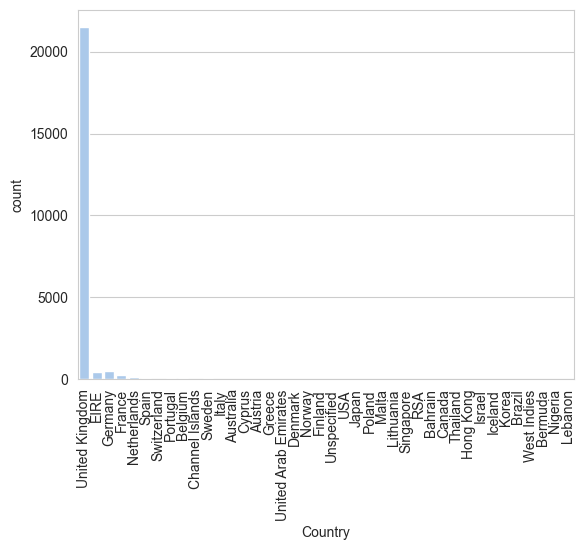

In [20]:
sns.countplot(data=df1_summary, x='Country', order=df1['Country'].value_counts().index)
plt.xticks(rotation=90);

In [ ]:
df_combine.describe()

,InvoiceDate,Amount,TotalItems,NumUniqueProd,AvgPrice
count,44876,44876.000000,44876.000000,44876.000000,44876.000000
mean,2010-12-22 15:54:32.081736192,364.196208,224.789955,18.039955,15.293512
min,2009-12-01 07:45:00,-168469.600000,-87167.000000,1.000000,0.000000
25%,2010-06-24 12:38:45,74.895000,24.000000,3.000000,2.060000
50%,2010-11-29 10:53:00,237.570000,115.000000,11.000000,2.950000
75%,2011-07-06 15:55:30,418.225000,248.000000,24.000000,4.300000
max,2011-12-09 12:50:00,168469.600000,87167.000000,542.000000,38970.000000
std,NaN,1563.904258,1311.212614,22.666221,298.454533


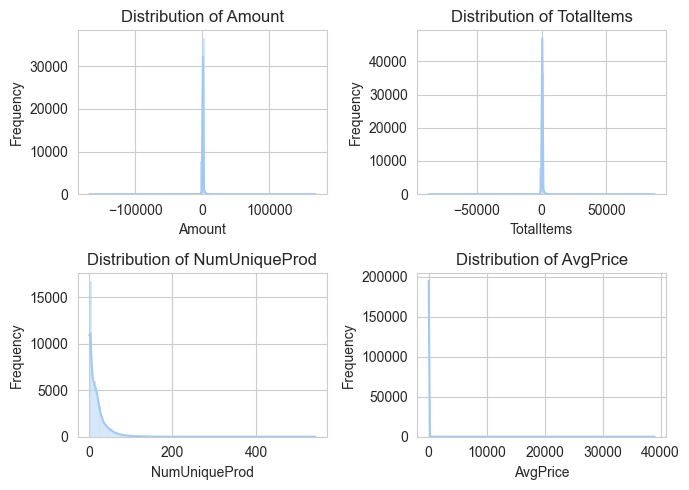

In [33]:
# List of features to plot
features = ['Amount', 'TotalItems', 'NumUniqueProd', 'AvgPrice']

# Set up the 2x2 subplot grid
plt.figure(figsize=(7, 5))

for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_combine[col], bins=100, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## lifetime data preparation

Assumption: In the customer value estimation, the negative order will be consider as business loss (burn) and will reduce the value estimate of such customers. The negative order invoice appears as return order invoice. However given the lack of Customer ID in the record, its not fessible to trace all the 

The negative order invoices are not dropped assuming that most of the positive original order should be part of the available record. Removing negative order will artifically amplify the value of customer using neutral (original + return) order.

In [62]:
# default freq of a day
summary(df_combine, 'Customer ID', 'InvoiceDate', 'Amount', observation_period_end=dt.datetime(2011, 12, 10)).head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346,10.0,400.0,726.0,-15.468000
12347,7.0,402.0,405.0,615.714286
12348,4.0,363.0,439.0,449.310000
12349,4.0,717.0,736.0,1107.172500
12350,0.0,0.0,311.0,0.000000


In [38]:
# revenue per order excluding the first order

summary_data = summary(df_combine, 'Customer ID', 'InvoiceDate', 'Amount', observation_period_end=dt.datetime(2011, 12, 10), freq='W')
summary_data.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346,8.0,57.0,103.0,-22.272500
12347,7.0,58.0,58.0,615.714286
12348,4.0,51.0,62.0,449.310000
12349,4.0,103.0,105.0,1107.172500
12350,0.0,0.0,44.0,0.000000


In [39]:
# average revenue per order
addon_data = df_combine.groupby('Customer ID')[['Amount']].mean().reset_index()
addon_data.columns = ['Customer ID', 'AvgOrderValue']
summary_data = summary_data.merge(addon_data, on='Customer ID', how='inner')
summary_data.head()

,Customer ID,frequency,recency,T,monetary_value,AvgOrderValue
0,12346,8.0,57.0,103.0,-22.272500,-3.804706
1,12347,7.0,58.0,58.0,615.714286,615.191250
2,12348,4.0,51.0,62.0,449.310000,403.880000
3,12349,4.0,103.0,105.0,1107.172500,880.908000
4,12350,0.0,0.0,44.0,0.000000,334.400000


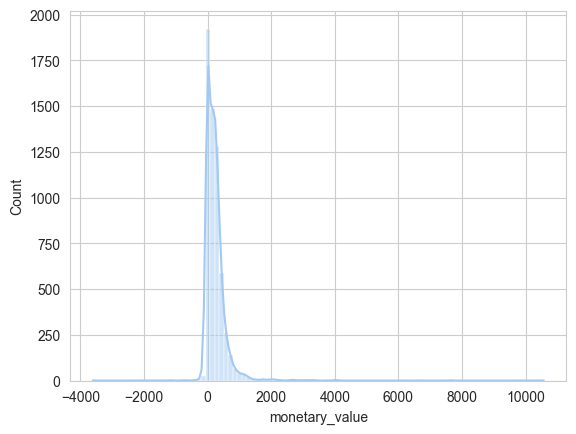

In [40]:
sns.histplot(summary_data['monetary_value'], bins=100, kde=True);

### 2nd attempt
gamma gamma fitter doesn't work with negative values; data preparation for lifetimes without negative orders

In [41]:
positive_order_df = df_combine[df_combine['Amount'] > 0]

positive_summary_data = summary(positive_order_df, 'Customer ID', 'InvoiceDate', 'Amount', observation_period_end=dt.datetime(2011, 12, 10), freq='W')
positive_summary_data.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346,6.0,57.0,103.0,12907.160000
12347,7.0,58.0,58.0,615.714286
12348,4.0,51.0,62.0,449.310000
12349,3.0,82.0,84.0,1120.056667
12350,0.0,0.0,44.0,0.000000


### experimental: monetary value calculation

In [38]:
customer_id_col = 'Customer ID'
datetime_col = 'InvoiceDate'
monetary_value_col = 'Amount'
 
df_combine_sorted = df_combine.sort_values(by=[customer_id_col, datetime_col])

# Mark first transaction per customer
df_combine_sorted['first'] = ~df_combine_sorted.duplicated(subset=customer_id_col, keep='first')

# Exclude first transaction for monetary value calculation
df_monetary = df_combine_sorted[~df_combine_sorted['first']]

# Calculate mean monetary value per customer
monetary_value = df_monetary.groupby(customer_id_col)[monetary_value_col].mean().fillna(0)

# To see result as a DataFrame
monetary_value_df = monetary_value.reset_index()

In [41]:
monetary_value_df

,Customer ID,Amount
0,12346.0,-6.855000
1,12347.0,615.714286
2,12348.0,449.310000
3,12349.0,1107.172500
4,12352.0,145.455000
...,...,...
4476,18282.0,38.195000
4477,18283.0,125.490476
4478,18284.0,-25.000000
4479,18286.0,362.740000


## clv calculation

### 1st attempt: using all order summary

In [42]:
bgf = BetaGeoFitter()
bgf.fit(summary_data['frequency'], summary_data['recency'], summary_data['T'])

# Predict expected purchases in the next 52 weeks ~ 1 year
# summary_data['predicted_purchases'] = bgf.predict(52, summary_data['frequency'], summary_data['recency'], summary_data['T'])
summary_data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    52, summary_data['frequency'], summary_data['recency'], summary_data['T']
)
summary_data.head()

,Customer ID,frequency,recency,T,monetary_value,AvgOrderValue,predicted_purchases
0,12346,8.0,57.0,103.0,-22.272500,-3.804706,1.627165
1,12347,7.0,58.0,58.0,615.714286,615.191250,5.702958
2,12348,4.0,51.0,62.0,449.310000,403.880000,3.173187
3,12349,4.0,103.0,105.0,1107.172500,880.908000,2.053120
4,12350,0.0,0.0,44.0,0.000000,334.400000,0.686717


In [43]:
summary_data.head()

,Customer ID,frequency,recency,T,monetary_value,AvgOrderValue,predicted_purchases
0,12346,8.0,57.0,103.0,-22.272500,-3.804706,1.627165
1,12347,7.0,58.0,58.0,615.714286,615.191250,5.702958
2,12348,4.0,51.0,62.0,449.310000,403.880000,3.173187
3,12349,4.0,103.0,105.0,1107.172500,880.908000,2.053120
4,12350,0.0,0.0,44.0,0.000000,334.400000,0.686717


In [ ]:
# gamma gamma require atleast 1 repeat purchase
monetary_data = summary_data[summary_data['frequency'] > 0]
# gamma gammma works only on +ve monetary values
floor = abs(monetary_data['monetary_value'].min())+1
monetary_data['monetary_value'] += floor

In [45]:
# Fit Gamma-Gamma Model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(monetary_data['frequency'], monetary_data['monetary_value'])

# Predict expected average transaction value
monetary_data['future_monetary_value'] = ggf.conditional_expected_average_profit(
    monetary_data['frequency'], monetary_data['monetary_value']
)
monetary_data['monetary_value'] -= floor
monetary_data['future_monetary_value'] -= floor

monetary_data.head()

,Customer ID,frequency,recency,T,monetary_value,AvgOrderValue,predicted_purchases,future_monetary_value
0,12346,8.0,57.0,103.0,-22.272500,-3.804706,1.627165,107.110901
1,12347,7.0,58.0,58.0,615.714286,615.191250,5.702958,790.686471
2,12348,4.0,51.0,62.0,449.310000,403.880000,3.173187,752.888453
3,12349,4.0,103.0,105.0,1107.172500,880.908000,2.053120,1459.805159
6,12352,8.0,51.0,56.0,218.182500,145.323846,6.552147,356.208566


In [46]:
# Predict CLV for the next 52 weeks
clv = ggf.customer_lifetime_value(
    bgf, 
    monetary_data['frequency'], 
    monetary_data['recency'], 
    monetary_data['T'], 
    monetary_data['monetary_value'],
    time=52,  
    discount_rate=0.01,  # 1% discount rate
    freq='W'
)

monetary_data['clv'] = clv
monetary_data.head()

,Customer ID,frequency,recency,T,monetary_value,AvgOrderValue,predicted_purchases,future_monetary_value,clv
0,12346,8.0,57.0,103.0,-22.272500,-3.804706,1.627165,107.110901,-118.698895
1,12347,7.0,58.0,58.0,615.714286,615.191250,5.702958,790.686471,11568.669593
2,12348,4.0,51.0,62.0,449.310000,403.880000,3.173187,752.888453,4865.453269
3,12349,4.0,103.0,105.0,1107.172500,880.908000,2.053120,1459.805159,7866.907473
6,12352,8.0,51.0,56.0,218.182500,145.323846,6.552147,356.208566,4684.744795


In [47]:
monetary_data

,Customer ID,frequency,recency,T,monetary_value,AvgOrderValue,predicted_purchases,future_monetary_value,clv
0,12346,8.0,57.0,103.0,-22.272500,-3.804706,1.627165,107.110901,-118.698895
1,12347,7.0,58.0,58.0,615.714286,615.191250,5.702958,790.686471,11568.669593
2,12348,4.0,51.0,62.0,449.310000,403.880000,3.173187,752.888453,4865.453269
3,12349,4.0,103.0,105.0,1107.172500,880.908000,2.053120,1459.805159,7866.907473
6,12352,8.0,51.0,56.0,218.182500,145.323846,6.552147,356.208566,4684.744795
...,...,...,...,...,...,...,...,...,...
5935,18281,1.0,56.0,82.0,80.820000,100.570000,0.864104,1503.470773,320.896616
5936,18282,2.0,17.0,18.0,38.195000,58.866667,4.701617,628.022577,665.046527
5937,18283,18.0,94.0,94.0,146.405556,124.393182,9.163286,205.425337,4370.034093
5940,18286,2.0,35.0,103.0,362.740000,396.143333,0.802959,1004.867446,1093.548998


### 2nd attempt: using only positive order summary

In [51]:
positive_monetary_data = positive_summary_data[positive_summary_data['frequency'] > 0]

In [52]:
# BG model for future purchases count
bgf2 = BetaGeoFitter()
bgf2.fit(positive_monetary_data['frequency'], positive_monetary_data['recency'], positive_monetary_data['T'])

# Predict expected purchases in the next 52 weeks ~ 1 year
# positive_monetary_data['predicted_purchases'] = bgf.predict(52, positive_monetary_data['frequency'], positive_monetary_data['recency'], positive_monetary_data['T'])
positive_monetary_data['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(
    52, positive_monetary_data['frequency'], positive_monetary_data['recency'], positive_monetary_data['T']
)
positive_monetary_data.head()

,frequency,recency,T,monetary_value,predicted_purchases
Customer ID,,,,,
12346,6.0,57.0,103.0,12907.160000,1.972773
12347,7.0,58.0,58.0,615.714286,5.707255
12348,4.0,51.0,62.0,449.310000,3.414380
12349,3.0,82.0,84.0,1120.056667,2.267513
12352,8.0,51.0,56.0,338.261250,6.466512


In [53]:
# Fit Gamma-Gamma Model for average transaction value
ggf2 = GammaGammaFitter(penalizer_coef=0.01)
ggf2.fit(positive_monetary_data['frequency'], positive_monetary_data['monetary_value'])

# Predict expected average transaction value
positive_monetary_data['future_monetary_value'] = ggf2.conditional_expected_average_profit(
    positive_monetary_data['frequency'], positive_monetary_data['monetary_value']
)

positive_monetary_data.head()

,frequency,recency,T,monetary_value,predicted_purchases,future_monetary_value
Customer ID,,,,,,
12346,6.0,57.0,103.0,12907.160000,1.972773,13296.618398
12347,7.0,58.0,58.0,615.714286,5.707255,632.084766
12348,4.0,51.0,62.0,449.310000,3.414380,470.887292
12349,3.0,82.0,84.0,1120.056667,2.267513,1190.940628
12352,8.0,51.0,56.0,338.261250,6.466512,346.317727


In [55]:
# Predict CLV for the next 52 weeks
clv = ggf2.customer_lifetime_value(
    bgf2, 
    positive_monetary_data['frequency'], 
    positive_monetary_data['recency'], 
    positive_monetary_data['T'], 
    positive_monetary_data['monetary_value'],
    time=52, 
    freq='W'
)

positive_monetary_data['clv'] = clv
positive_monetary_data.head()

,frequency,recency,T,monetary_value,predicted_purchases,future_monetary_value,clv
Customer ID,,,,,,,
12346,6.0,57.0,103.0,12907.160000,1.972773,13296.618398,84906.907876
12347,7.0,58.0,58.0,615.714286,5.707255,632.084766,11546.712547
12348,4.0,51.0,62.0,449.310000,3.414380,470.887292,5138.642322
12349,3.0,82.0,84.0,1120.056667,2.267513,1190.940628,8671.074244
12352,8.0,51.0,56.0,338.261250,6.466512,346.317727,7166.874697


In [56]:
top_customers = positive_monetary_data.sort_values('clv', ascending=False).head(10)
top_customers

,frequency,recency,T,monetary_value,predicted_purchases,future_monetary_value,clv
Customer ID,,,,,,,
16446,1.0,29.0,29.0,168469.600000,2.594703,204324.712275,1.653210e+06
18102,50.0,105.0,105.0,11204.516000,21.413434,11244.048005,7.830866e+05
14646,61.0,105.0,105.0,8571.991475,25.977166,8596.780044,7.264135e+05
17450,22.0,61.0,62.0,9322.857727,14.902898,9397.979707,4.503289e+05
14156,72.0,104.0,105.0,4333.169306,30.507104,4343.806294,4.310887e+05
14911,94.0,105.0,105.0,3093.908723,39.668010,3099.733984,4.000469e+05
14096,14.0,14.0,14.0,4645.695000,23.899297,4704.925442,3.526645e+05
12415,20.0,72.0,75.0,7106.581500,11.733470,7169.666351,2.714795e+05
13694,62.0,105.0,105.0,3114.690323,26.392046,3123.589682,2.681560e+05


Text(0.5, 1.0, 'Customer Lifetime Value Segmentation')

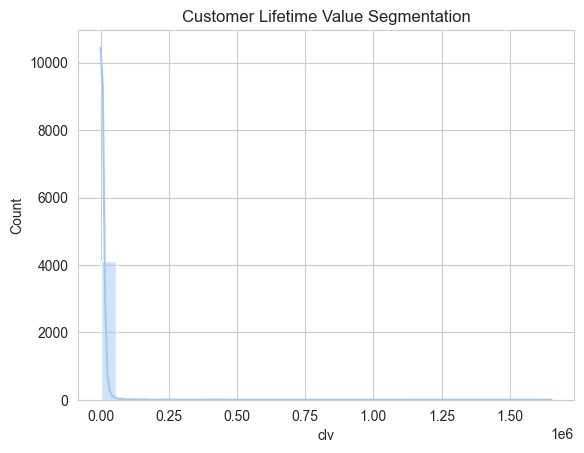

In [57]:
sns.histplot(positive_monetary_data['clv'], bins=30, kde=True)
plt.title('Customer Lifetime Value Segmentation')

In [58]:
positive_monetary_data['clv_segment'] = pd.qcut(positive_monetary_data['clv'], 4, labels=['Low', 'Mid', 'High', 'Top'])
positive_monetary_data

,frequency,recency,T,monetary_value,predicted_purchases,future_monetary_value,clv,clv_segment
Customer ID,,,,,,,,
12346,6.0,57.0,103.0,12907.160000,1.972773,13296.618398,84906.907876,Top
12347,7.0,58.0,58.0,615.714286,5.707255,632.084766,11546.712547,Top
12348,4.0,51.0,62.0,449.310000,3.414380,470.887292,5138.642322,High
12349,3.0,82.0,84.0,1120.056667,2.267513,1190.940628,8671.074244,Top
12352,8.0,51.0,56.0,338.261250,6.466512,346.317727,7166.874697,Top
...,...,...,...,...,...,...,...,...
18281,1.0,56.0,82.0,80.820000,1.130056,102.488878,368.648202,Low
18282,1.0,17.0,18.0,77.840000,3.319463,98.874729,1016.750396,Low
18283,18.0,94.0,94.0,146.405556,8.918894,148.053544,4279.981195,High
